<a href="https://colab.research.google.com/github/ilaig2/siren/blob/master/siren_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from glob import glob
image_paths = glob('/content/drive/MyDrive/Data/48/*.png')

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen,  dim=2, min_val=-1, max_val=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(min_val, max_val, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [4]:
from collections import OrderedDict
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30., **kwargs):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [5]:
class ImageEmbedding(nn.Module):
      def __init__(self, num_images, embedding_size, embedding_bias=True, nl='relu', **kwargs):
        super().__init__()
        self.num_images = num_images
        self.nl_type = nl
        self.linear = nn.Linear(num_images, embedding_size, bias=embedding_bias)
        if nl == 'relu':
          self.nl = nn.ReLU()
        
        self.init_weights()

      def init_weights(self):
        m = self.linear
        if type(m) == nn.Linear:
          if hasattr(m, 'weight'):
              nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity=self.nl_type, mode='fan_in')
          if hasattr(m, 'weight'):
              m.bias.data.fill_(0.01)

      def forward(self, image_idx):
        image_idx = image_idx.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.nl(self.linear(image_idx))
        return output

class MultiImageSiren(nn.Module):
      def __init__(self, in_features, num_images, embedding_size, hidden_features, hidden_layers, out_features, **kwargs):
        super().__init__()
        self.embedder_net = ImageEmbedding(num_images, embedding_size, **kwargs)
        self.siren = Siren(in_features + embedding_size, hidden_features, hidden_layers, out_features, **kwargs)

      def forward(self, coords, image_idx):
        embedding = self.embedder_net(image_idx)
        expand_dims = (-1, coords.shape[-2], -1) if embedding.ndim == 3 else (coords.shape[-2], -1)
        sine_input = torch.cat((coords, embedding.expand(*expand_dims)), dim=-1)
        pixels, _ = self.siren(sine_input)
        return pixels, embedding



#Ilai: My code starts here

(All the code above is from the original Siren repo, unchanged)

# Fitting two images

By adding an additional input channel which encodes the image number - the network is able to learn the representations of two different images.

In [6]:
def image_transforms(img , sidelength):
      transform = Compose([
        Resize((sidelength, sidelength)),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
      ])
      img = transform(img)
      return img

class MultiImageFitting(Dataset):
    def __init__(self, sidelength, image_paths):
        super().__init__()
        self.sidelength = sidelength
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):    
        img = Image.open(self.image_paths[idx])
        img = image_transforms(img, self.sidelength)
        pixels = img.permute(1, 2, 0).view(-1, img.shape[0])
        pixels = pixels[:, :3]
        coords = get_mgrid(self.sidelength, 2)
        
        one_hot_idx = F.one_hot(torch.tensor([idx]), num_classes=len(self.image_paths)).float()
            
        return coords, one_hot_idx, pixels

In [7]:
SIDELENGTH = 48
NUM_IMAGES = len(image_paths)
EMBEDDING_SIZE = 512
BATCH_SIZE = 100 # Wich essentially means "real" gradient decsent, not SGD
# BATCH_SIZE = 32 

#device='cuda'
device='cpu'

img_siren = MultiImageSiren(in_features=2, num_images=NUM_IMAGES, 
                            embedding_size=EMBEDDING_SIZE,
                            out_features=3, hidden_features=256, 
                            hidden_layers=3, outermost_linear=True)


images_48_ds = MultiImageFitting(SIDELENGTH, image_paths)
dataloader = DataLoader(images_48_ds, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0)

img_siren.to(device)

MultiImageSiren(
  (embedder_net): ImageEmbedding(
    (linear): Linear(in_features=100, out_features=512, bias=True)
    (nl): ReLU()
  )
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=514, out_features=256, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (3): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (4): Linear(in_features=256, out_features=3, bias=True)
    )
  )
)

In [535]:
total_steps = 2000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 50
best_loss = 1e6
CKPT_NAME = f'img_siren_side_{SIDELENGTH}_embedding_{EMBEDDING_SIZE}_batch_{BATCH_SIZE}_cont_lr_e-5.pth'
CKPT_PATH = os.path.join('/content/drive/MyDrive/model_ckpts/', CKPT_NAME)

optim = torch.optim.Adam(lr=1e-5, params=img_siren.parameters())

for step in range(total_steps):
  epoch_loss = 0
  for coords, one_hot_idx, ground_truth in dataloader:
    coords, one_hot_idx, ground_truth = coords.cuda(), one_hot_idx.cuda(), ground_truth.cuda()
    model_output, embdedding = img_siren(coords, one_hot_idx)    
    loss = ((model_output - ground_truth)**2).mean()
    epoch_loss += ((model_output.detach() - ground_truth.detach())**2).view(model_output.shape[0], -1).mean(dim=1).sum()

    optim.zero_grad()
    loss.backward()
    optim.step()

  epoch_loss = epoch_loss / len(dataloader.dataset)
  if not step % steps_til_summary:
    print("Step %d, Total loss %0.6f" % (step, epoch_loss))
    if epoch_loss < best_loss:
      torch.save(img_siren.state_dict(), CKPT_PATH)
      best_loss = epoch_loss

Step 0, Total loss 0.715167


KeyboardInterrupt: ignored

Best losses so far:

1. `embedding_size=256`, `batch_size=32` (about 2000 steps): `0.09` (epoch loss calculated incorrectly, need to repeat)  
2. `embedding_size=512`, `batch_size=100` (about 1800 steps): `0.019`  
3. `embedding_size=512`, `batch_size=32` (about 1700 steps): `0.021`  
4. Continue training (2.) with `lr=1e-5`(additional 1400 epochs): `0.01`

In [293]:
# CKPT_PATH = os.path.join('/content/drive/MyDrive/model_ckpts/', CKPT_NAME)
BEST_CKPT_PATH = '/content/drive/MyDrive/model_ckpts/img_siren_side_48_embedding_512_batch_100.pth'
# BEST_CKPT_PATH = '/content/drive/MyDrive/model_ckpts/img_siren_side_48_embedding_512_batch_100_cont_lr_e-5.pth'

In [294]:
device = torch.device('cuda')
img_siren.load_state_dict(torch.load(BEST_CKPT_PATH, map_location=device))
img_siren.eval() # Kinda meaningless, since the model has no layers that behave differently in train \ eval.

MultiImageSiren(
  (embedder_net): ImageEmbedding(
    (linear): Linear(in_features=100, out_features=512, bias=True)
    (nl): ReLU()
  )
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=514, out_features=256, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (3): SineLayer(
        (linear): Linear(in_features=256, out_features=256, bias=True)
      )
      (4): Linear(in_features=256, out_features=3, bias=True)
    )
  )
)

# Verify and visualize trained model forward()
Since the model is size agnostic, it can up\downsample the image to any desired resolution (to some precision...)

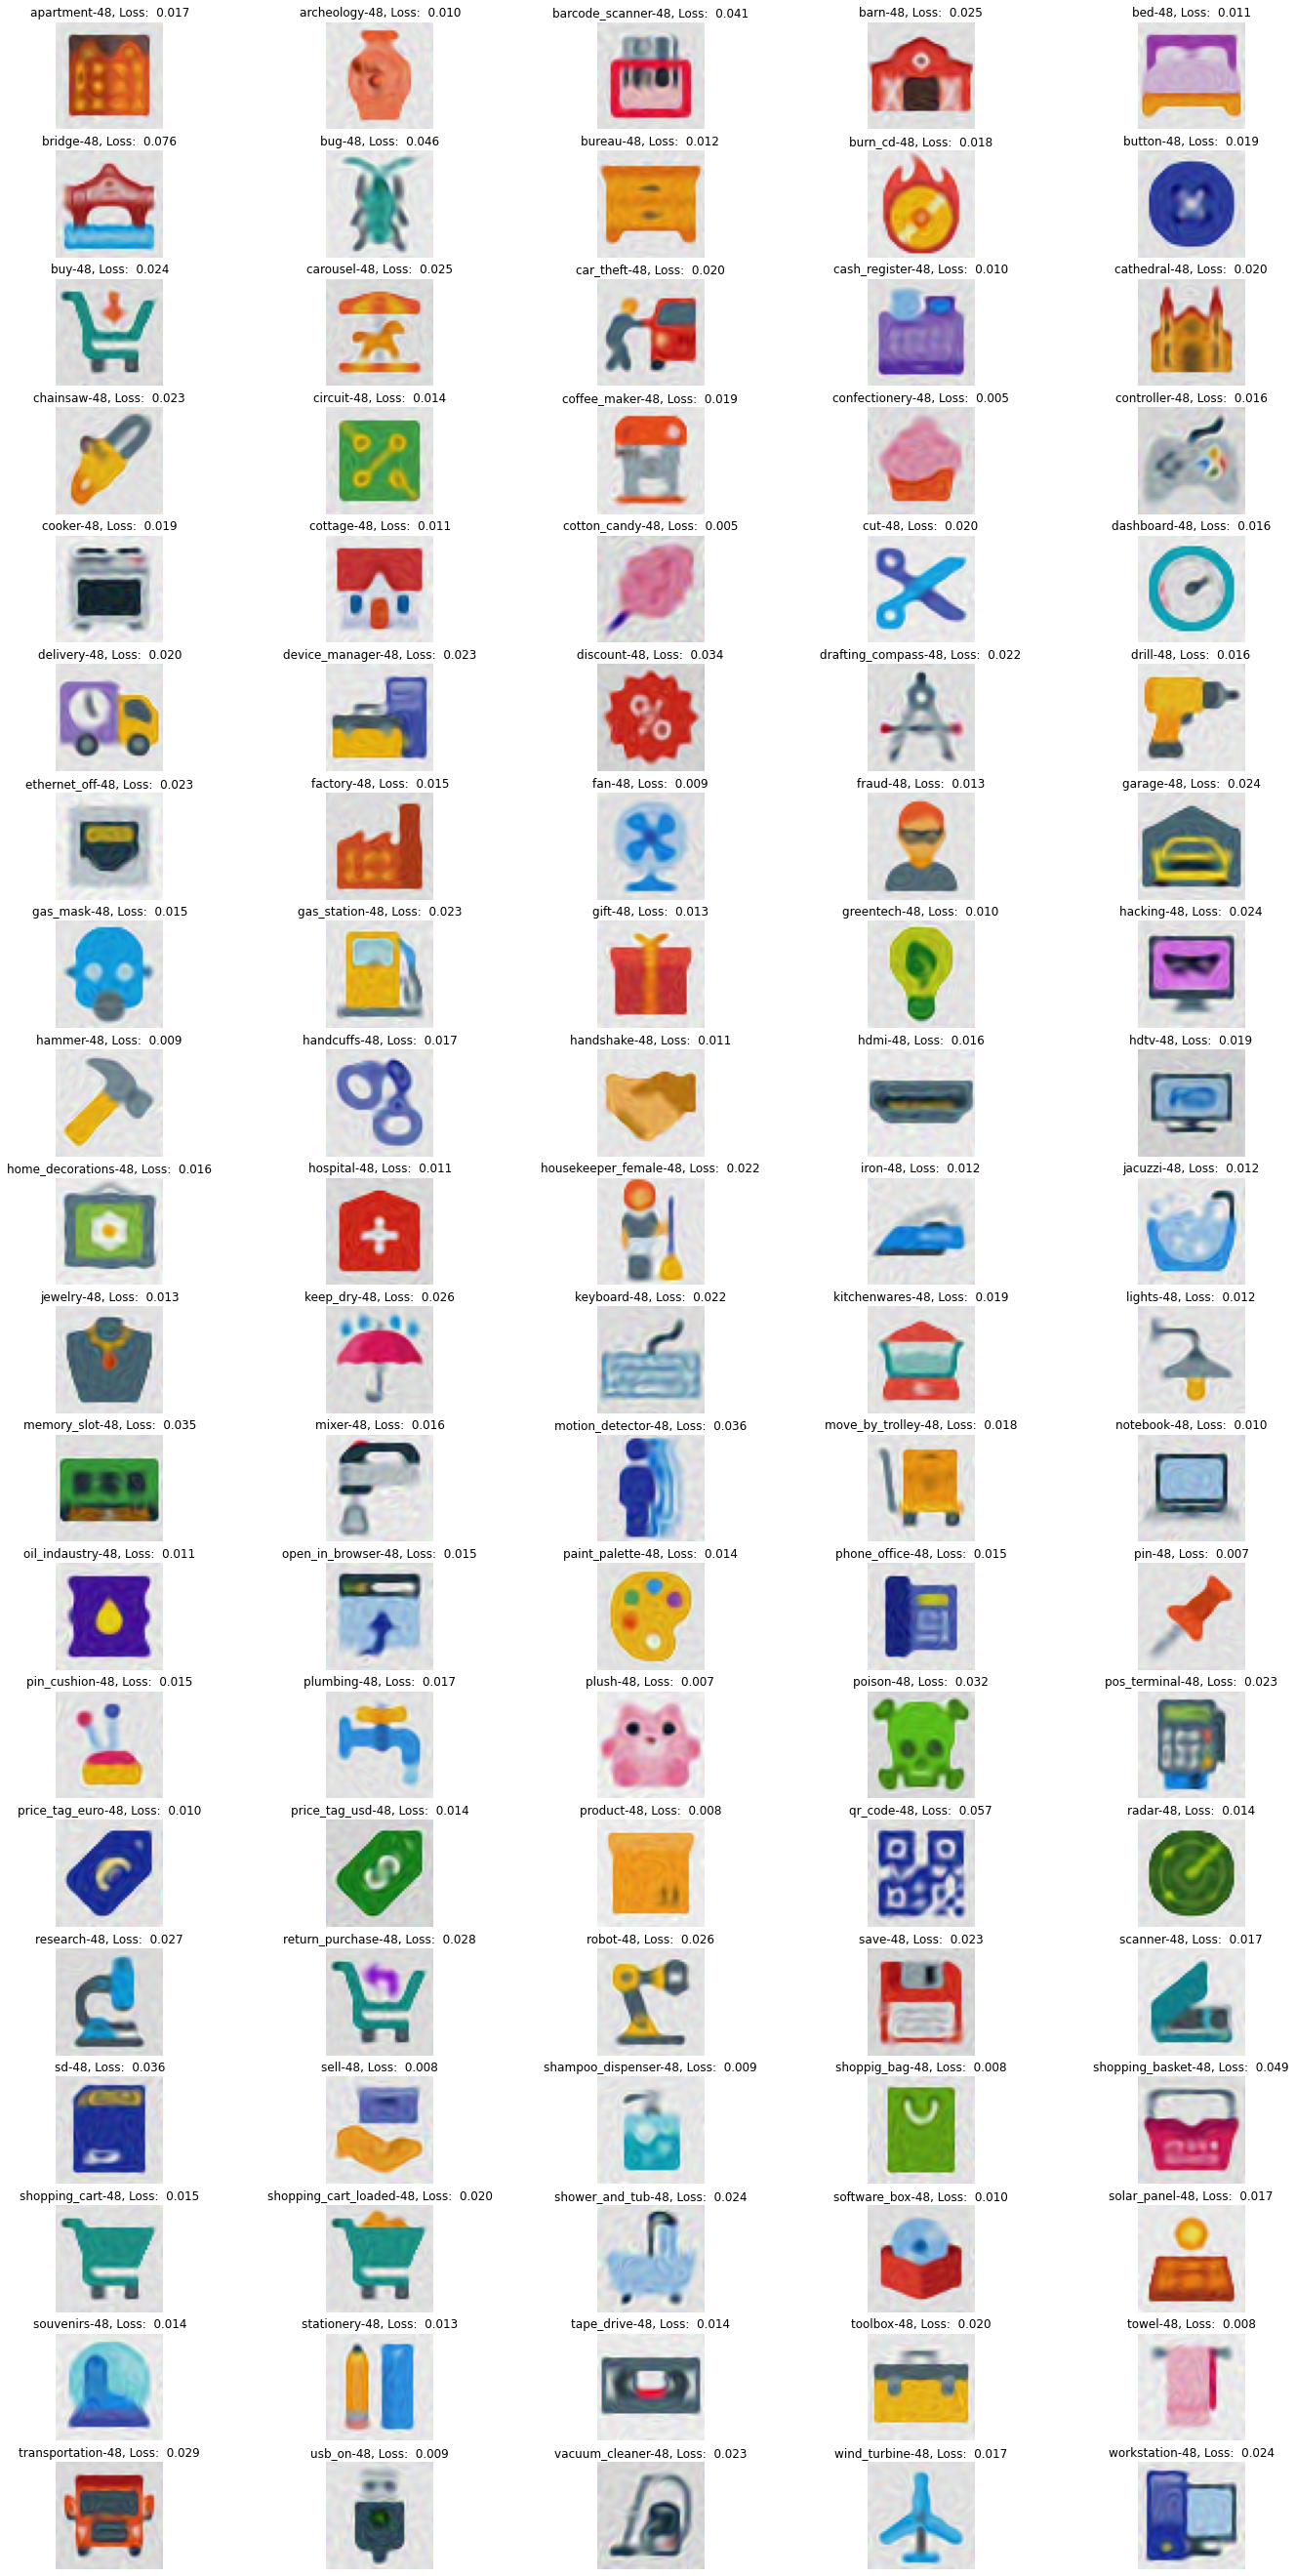

In [295]:
NEW_SIDELENGTH = 48
camera_and_coins = MultiImageFitting(NEW_SIDELENGTH, images)
dataloader = DataLoader(camera_and_coins, batch_size=1, pin_memory=True, num_workers=0)

fig, axs = plt.subplots(20, 5, figsize=[24,48])

with torch.no_grad():
  for i, (coords, one_hot_idx, GT) in enumerate(dataloader):
      model_output, _ = img_siren(coords.cuda(), one_hot_idx.cuda())
      model_output = model_output.cpu()
      loss = ((model_output - GT)**2).mean()
      model_output = model_output.view(NEW_SIDELENGTH,NEW_SIDELENGTH, 3).numpy()
      model_output -= model_output.min()
      model_output /= (model_output.max() - model_output.min())
      axs[(i //5) % 20, i % 5].imshow(model_output, cmap='gray')
      axs[(i //5) % 20, i % 5].set_title(f"{os.path.splitext(os.path.basename(images[i]))[0]}, Loss: {loss : .3f}")
      axs[(i //5) % 20, i % 5].axis(False)

# Explore generalization
Let's deny the model one quarter of the image - one corner (top left, bottom right etc) from each image.   
We'll start by cropping different parts from each invidiual image - so that the model is still overall trained with the full coordiante space.

In [19]:
def eavluate(model, val_dataloader):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
      for coords, one_hot_idx, ground_truth in val_dataloader:
        coords, one_hot_idx, ground_truth = coords.to(device), one_hot_idx.to(device), ground_truth.to(device)
        model_output, _ = model(coords, one_hot_idx)
        epoch_loss += ((model_output.detach() - ground_truth.detach())**2).view(model_output.shape[0], -1).mean(dim=1).sum()
      
      epoch_loss = epoch_loss / len(val_dataloader.dataset)
  
  model.train()
  return epoch_loss

In [20]:
def trainig_loop(model, train_dataloader, val_dataloader, total_steps=2000, steps_til_summary=50):
  optim = torch.optim.Adam(lr=1e-4, params=model.parameters())

  for step in range(total_steps):
    epoch_loss = 0
    for coords, one_hot_idx, ground_truth in train_dataloader:
      coords, one_hot_idx, ground_truth = coords.to(device), one_hot_idx.to(device), ground_truth.to(device)
      model_output, embdedding = model(coords, one_hot_idx)    
      loss = ((model_output - ground_truth)**2).mean()
      epoch_loss += ((model_output.detach() - ground_truth.detach())**2).view(model_output.shape[0], -1).mean(dim=1).sum()

      optim.zero_grad()
      loss.backward()
      optim.step()

    epoch_loss = epoch_loss / len(dataloader.dataset)
    if step % steps_til_summary == 0:
      val_loss = eavluate(model, val_dataloader)
      print(f"Epoch {step}, Train loss {epoch_loss :0.4f}, Val loss {val_loss :0.4f}")

It's pretty obvious (and not too surprising) that the network can't generalize to a part of the image it has never seen at all (in any of the images).  

Let's try instead to randomly remove one _arbitrary_ corner from each image (different corners from different images).

In [21]:
def mask_out_corner(img:np.ndarray, portion: float, sidelength:int,
                   corner:str = 'tl') -> np.ndarray:
  del_side = int(portion * sidelength)

  crop_val = torch.Tensor([-100] * img.shape[-1])
  if corner == 'tl':
    img[:del_side, :del_side, :] = crop_val
  elif corner == 'tr':
    img[:del_side, (sidelength - del_side) : sidelength , :] = crop_val
  elif corner == 'bl':
    img[(sidelength - del_side) : sidelength, :del_side, :] = crop_val
  elif corner == 'br':
    img[(sidelength - del_side) : sidelength, 
        (sidelength - del_side) : sidelength, :] = crop_val

  return img


class MultiImageFittingPartialRand(Dataset):
    def __init__(self, sidelength:int, image_paths:list, del_portion:float = 1):
        super().__init__()
        self.sidelength = sidelength
        self.del_portion = del_portion
        self.image_paths = image_paths
        self.corners = [np.random.choice(['tl', 'tr', 'bl', 'br']) for _ in range(len(image_paths))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):    
        img = Image.open(self.image_paths[idx])
        img = image_transforms(img, self.sidelength)
        img = img.permute(1, 2, 0)
        
        # Randomly delete one part of the image (ugly implementation, but it'll work...)
        corner = self.corners[idx]
        img = mask_out_corner(img, self.del_portion, self.sidelength, corner)
        pixels = img.reshape(-1, img.shape[-1])
        pixels = pixels[:, :3]
        mask_2d = pixels[:, 0] != -100
        pixels = pixels[mask_2d, :]
        coords = get_mgrid(self.sidelength, 2)
        coords = coords[mask_2d, :]
        
        one_hot_idx = F.one_hot(torch.tensor([idx]), num_classes=len(self.image_paths)).float()
            
        return coords, one_hot_idx, pixels

In [22]:
SIDELENGTH = 48
NUM_IMAGES = len(image_paths)
EMBEDDING_SIZE = 512
BATCH_SIZE = 100 # Wich essentially means "real" gradient decsent, not SGD
# BATCH_SIZE = 32

#device='cuda'
device='cpu'

# TODO: add model.init_weights(), so I don't need to instantiate a new obj every time...
img_siren = MultiImageSiren(in_features=2, num_images=NUM_IMAGES, 
                            embedding_size=EMBEDDING_SIZE,
                            out_features=3, hidden_features=256, 
                            hidden_layers=3, outermost_linear=True)

img_siren.to(device)

# Create a train ds that removes bottom left quarter of the images (both coordinates and pixel values)
train_ds = MultiImageFittingPartialRand(SIDELENGTH, image_paths, 0.5)
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0)

# Create a validation ds that loads the full images
val_ds = MultiImageFittingPartialRand(SIDELENGTH, image_paths, 0)
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0)

In [23]:
trainig_loop(img_siren, train_dataloader, val_dataloader, total_steps=1500, steps_til_summary=50)

Epoch 0, Train loss 0.7553, Val loss 0.6123
Epoch 50, Train loss 0.3187, Val loss 0.3207


KeyboardInterrupt: ignored

Let's see what this model is doing if we try to draw the images:

In [ ]:
NEW_SIDELENGTH = 48
dataloader = DataLoader(val_ds, batch_size=1, pin_memory=True, num_workers=0)

fig, axs = plt.subplots(20, 5, figsize=[24,48])

with torch.no_grad():
  for i, (coords, one_hot_idx, GT) in enumerate(dataloader):
      model_output, _ = img_siren(coords.cuda(), one_hot_idx.cuda())
      model_output = model_output.cpu()
      loss = ((model_output - GT)**2).mean()
      model_output = model_output.view(NEW_SIDELENGTH,NEW_SIDELENGTH, 3).numpy()
      model_output -= model_output.min()
      model_output /= (model_output.max() - model_output.min())
      axs[(i //5) % 20, i % 5].imshow(model_output, cmap='gray')
      axs[(i //5) % 20, i % 5].set_title(f"{os.path.splitext(os.path.basename(images[i]))[0]}, Loss: {loss : .3f}")
      axs[(i //5) % 20, i % 5].axis(False)

Now let's try to remove the **same** corner from all images.  
This should be harder for the model to generalize - since it has never seen an entire part of the coordinates space.


In [ ]:
class MultiImageFittingPartialBL(MultiImageFittingPartialRand):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.corners = ['br'] * len(self.image_paths)

In [ ]:
# TODO: add model.init_weights(), so I don't need to instantiate a new obj every time...
img_siren = MultiImageSiren(in_features=2, num_images=NUM_IMAGES, 
                            embedding_size=EMBEDDING_SIZE,
                            out_features=3, hidden_features=256, 
                            hidden_layers=3, outermost_linear=True)
img_siren.to(device)

# Create a train ds that removes bottom left quarter of the images (both coordinates and pixel values)
train_ds = MultiImageFittingPartialBL(SIDELENGTH, image_paths, 0.5)
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, pin_memory=True, num_workers=0)

Let's see what this model is doing if we try to draw the images:

In [ ]:
NEW_SIDELENGTH = 48
dataloader = DataLoader(val_ds, batch_size=1, pin_memory=True, num_workers=0)

fig, axs = plt.subplots(20, 5, figsize=[24,48])

with torch.no_grad():
  for i, (coords, one_hot_idx, GT) in enumerate(dataloader):
      model_output, _ = img_siren(coords.cuda(), one_hot_idx.cuda())
      model_output = model_output.cpu()
      loss = ((model_output - GT)**2).mean()
      model_output = model_output.view(NEW_SIDELENGTH,NEW_SIDELENGTH, 3).numpy()
      model_output -= model_output.min()
      model_output /= (model_output.max() - model_output.min())
      axs[(i //5) % 20, i % 5].imshow(model_output, cmap='gray')
      axs[(i //5) % 20, i % 5].set_title(f"{os.path.splitext(os.path.basename(images[i]))[0]}, Loss: {loss : .3f}")
      axs[(i //5) % 20, i % 5].axis(False)